<div class="alert alert-block alert-warning">
    To make sure you get the most of your time, 
    please make sure that you are able to run this notebook without problems 
    <b>before</b> starting to work on this part of the coursework.    
    In doing that, you do not really need to read most of the content of this notebook
    except for boxes highlighted just like this one.
    This notebook requires a Windows or Mac computer/laptop with Jupyter.
    Basically, it requires the same setup as the programming course you completed before.
    Because this notebook manipulates Excel spreadsheets,
    you will also need a copy of Microsoft Excel installed in the same machine.
</div>

<div class="alert alert-block alert-warning">
    This notebook requires external files and folders that are provided alongside it.
    Please do not remove/rename/relocate these as otherwise things will fail.
    Start from a fresh copy of this example where in doubt of what went wrong.
</div>

# Motivation

This notebook demonstrates at a high level an approach that you might find useful for your exercise.
It does so using an example *unrelated* to your area of application,
but the topic has been selected so that you can use your intuition as to what it all means.
When it comes to this course and your exercise, 
the idea is that you focus here on the key elements of the problem, 
and how those key elements translate into code that helps solve a task.

As a spoiler, this notebook reads hourly weather data for a year, performs some calculations, and produces a summary report in Excel:

![Figure: Overview of input and output](xref/figure1.png)

# The goal of this example notebook

In this example, someone is interested evaluating the potential heat stress risk for people indoors.
Because the indoor space is well ventilated,
it makes sense to assume that indoor conditions are similar to outdoors ones 
for air temperature and relative humidity, as a first approximation.
Thus, the location matters.

In a nutshell, how hot an environment feels is mainly determined by air temperature:
a room at 40 °C feels (and is) hotter than a room at 35 °C, all other things being equal.
However, humidity also plays a role.
A room at 35 °C and 90% relative humidity feels hotter than the same room at 35 °C and 10% relative humidity.
The reason is that our ability to dissipate heat via sweating becomes less and less effective as the relative humidity increases.
This description is an oversimplification, and more factors come into play, but this is not important for this exercise.

Long story short, people have created indices that consider the combined effect of temperature and humidity.
Such indices allow to:
1. Compare situations like an environment at {35 °C, 30%} and another at {30 °C, 80%}.
2. Give some idea as to how dangerous a hot environment might be.

At a high level, this task involves:
1. Getting typical weather conditions for the location.
2. Use a heat stress index to 'normalise' environmental conditions given by the weather description.
3. Report if and when conditions surpass recommended levels for the index being used.

In practice, this is just an excuse to:
1. Read tabular information from a file in Python (weather conditions).
1. Plot information (get an idea about the location, interim calculations, results...).
1. Implement a small mathematical model in Python step by step (the heat stress index).
1. Put previous pieces together to solve the problem (estimate heat stress in the given location).
1. Report results in a way that others find useful (produce a report in Excel).

As a bonus, you will get to see `pandas` and `xlwings` in action. 
These packages might be new to you, so feel free to explore their respective documentations to see
what they can offer and how to go about using them (see [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) and [xlwings](https://docs.xlwings.org/en/stable/index.html)).
This notebook will demonstrate some bits. 
Of these, some will be useful for your task while others will give you a flavour for things you might find useful at some other point of your studies or professional career.


# Approach

## Materials and methods

* We could study any location in the world. For results to be more meaningful, a hot, somewhat humid location would be preferable. 
  * For this example, we will use [Abu Dhabi](https://en.wikipedia.org/wiki/Abu_Dhabi#Climate), as it features a hot desert climate, next to the coast.
  * Its weather data is available [here](https://energyplus-weather.s3.amazonaws.com/asia_wmo_region_2/ARE/ARE_Abu.Dhabi.412170_IWEC/ARE_Abu.Dhabi.412170_IWEC.zip).
      * This is a ZIP file containing what is called an EPW file, a *text file* that describes weather for building performance simulation.
      * This type of weather data has been selected on purpose to put in practice some basic data reading and manipulation in Python.
* There are more than 100 heat indices in the literature, some of which are superseded by others, some of which are more suited for certain applications than others.
  * For this example, we will use Steadman's Apparent Temperature ([1984](http://journals.ametsoc.org/doi/abs/10.1175/1520-0450(1984)023%3C1674:AUSOAT%3E2.0.CO;2)), the version for 'Indoors'.
  * This is a very small model: just one equation with two independent variables.
  * The scale describes a normalised 'temperature' (called apparent temperature) and is similar to degrees Celsius.
  * In this scale, conditions start feeling hot at 30 and it becomes serious at around 35 to 40.

The information is presented as needed in this notebook, but overall, you will see that:
1. From the weather data we can extract the temperature and relative humidity.
2. The heat stress index needs the temperature and partial vapour pressure.
   * The air temperature is directly available from the weather data.
   * The partial vapour pressure needs to be calculated, which can be done from the temperature and relative humidity in the weather data.
   
![Overview of method](xref/figure2.png)
   
Once all the key information is available, it will be reported in Excel using a template prepared in advance:

![Overview of reporting](xref/figure3.png)

This notebook contains all the code, and the auxiliary files are in subfolders:
* The folder `1-input` contains a copy of the weather file and a template for the report in Excel (note that its numbers are made up!).
* The folder `2-output` contains the output report, which is produced by this notebook.
* The folder `xref` contains the images referenced in this notebook.

# Python setup

Let's import some modules that will help completing things.
It is good practice to list them first thing at the top of the code,
to see if you are missing something that is needed later on
(but you can import things as you go as well).

In [1]:
# Imports from the standard library: these are bundled with a regular python installation
from pathlib import Path  # This helps manipulating file paths

# Third party libraries: you may need to install some of these if you don't have them available
import numpy as np   # To work with arrays
import pandas as pd  # To work with tabular data and time series, this might be new to you

import matplotlib.pyplot as plt  # To plot things

<div class="alert alert-block alert-warning">
    Errors on the previous cell? Please read the information below, otherwise please carry on.
</div>

If you get an error like

```python
ModuleNotFoundError: No module named <name of the package>
```

it means the module is available in the working Python environment.
How to install it can depend on the module and the authors of the packages
usually have instructions on how to do it.
This tends to boil down to two typical ways.
If you open a terminal where Python is available (like the Anaconda Prompt) (but not starting Python!),
you can issue:

```
python -m pip install <name of the package>
```

or

```
conda install <name of the package>
```

Those commands should install [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) and [xlwings](https://docs.xlwings.org/en/stable/index.html), two of the packages this notebook uses.
If all goes well, you should be able to restart the notebook and execute it again so the new packages are picked up if that did not happened already (remember that you need to re-run the cell that imports the modules).

Please do not attempt to carry on with the notebook until previous cells work successfully.

# Weather data

## Load data

First, let's define where is the file with the weather data.

In [2]:
path = Path('1-input/ARE_Abu.Dhabi.412170_IWEC.epw')

# As a precaution, check that the file exists
if not path.exists():
    raise ValueError(f"Cannot find path={str(path)}")

<div class="alert alert-block alert-warning">
    If the previous cell raises the <code>Value Error: Cannot find path=...</code> error then one of the auxiliary files is missing.
    See the second alert box of this notebook on why this might have happened and how to fix it.
</div>

An EPW is really a text file, and you can open it with a text editor or 
visualise it in any other way that is convenient to you.
This is what you would normally do to get familiar with the file.

Also, you can read it directly from Python.
As a warning, the file has several thousand lines, so let's have a look at a few lines.

In [3]:
content = path.read_text().splitlines()
n_lines = 10  # Number of lines to show
n_chars = 80  # Maximum line length to display

print(f"Looking at the first {n_lines} lines of `{path.name}`")
print("-" * 120)
for i, line in enumerate(content[:n_lines], start=1):
    end = '... (line continues)' if len(line) > n_chars else ''        
    print(f"Line {i:04}: {line[:n_chars]}" + end)

print()

print(f"Looking at the last {n_lines} lines of `{path.name}`")
print("-" * 120)
for i, line in enumerate(content[-n_lines:], start=len(content) - n_lines + 1):
    end = '... (line continues)' if len(line) > n_chars else '' 
    print(f"Line {i:03}: {line[:n_chars]}" + end)

Looking at the first 10 lines of `ARE_Abu.Dhabi.412170_IWEC.epw`
------------------------------------------------------------------------------------------------------------------------
Line 0001: LOCATION,ABU DHABI,-,ARE,IWEC Data,412170,24.43,54.65,4.0,27.0
Line 0002: DESIGN CONDITIONS,1,Climate Design Data 2009 ASHRAE Handbook,,Heating,1,11.5,12.... (line continues)
Line 0003: TYPICAL/EXTREME PERIODS,6,Summer - Week Nearest Max Temperature For Period,Extre... (line continues)
Line 0004: GROUND TEMPERATURES,3,.5,,,,22.80,20.20,19.49,20.11,23.61,27.54,31.23,33.91,34.6... (line continues)
Line 0005: HOLIDAYS/DAYLIGHT SAVINGS,No,0,0,0
Line 0006: COMMENTS 1,"IWEC- WMO#412170 - Asia -- Original Source Data (c) 2001 American So... (line continues)
Line 0007: COMMENTS 2, -- Ground temps produced with a standard soil diffusivity of 2.32257... (line continues)
Line 0008: DATA PERIODS,1,1,Data,Sunday, 1/ 1,12/31
Line 0009: 1997,1,1,1,60,C9C9C9C9*0?9?9?9?9?9?9?9A7A7C8C8A7*0*0E8*0*0,16.0,12.3,78

For the purpose of this demonstration, all we need to know is that:
* Like all text files, the file contains lines.
* In this kind of text file (epw), each line contains a fields separated by commas.
* The fields are defined by position. Thus, we need the documentation of EPW files to understand it.
    * Such documentation is [here](https://climate.onebuilding.org/papers/EnergyPlus_Weather_File_Format.pdf), but you **do not need to look at it**, this notebook includes all you need to know.
    * For example, the last field in line 1 has the elevation in meters above sea level (27m in this case).
* The file has a header that comprises lines 1 to 8.
* Lines 9 and onwards hold the table with the weather data.
  * The header of the table is not available in the file, it is defined by position.
  * Weather data in EPW files is conventionally reported hourly and for non-leap years, so the body is expected to have $1 \frac{line}{hour} \times 24 \frac{hour}{day} \times 365 \frac{day}{year} = 8760 \frac{line}{year}$. This file seems to be no exception, as it has 8768 lines (8 for the header, 8760 for the actual weather data).
  * For the purpose of this demonstration, we will assume that the data in this file is continuous in time (but in reality it is not for reasons that we do not need to get into here).
  
Overall, the EPW file behaves like a [CSV file](https://en.wikipedia.org/wiki/Comma-separated_values).
Thus, it seems like pandas' [read_csv function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) would be a practical way to read the tabular section of the file:

In [4]:
df_raw = pd.read_csv(path, skiprows=8, header=None)
df_raw

0   1   2   3   4                                             5   \
0     1997   1   1   1  60  C9C9C9C9*0?9?9?9?9?9?9?9A7A7C8C8A7*0*0E8*0*0   
1     1997   1   1   2  60  C9C9C9C9*0?9?9?9?9?9?9?9A7A7C8C8A7*0*0E8*0*0   
2     1997   1   1   3  60  C9C9C9C9*0?9?9?9?9?9?9?9A7A7C8C8A7*0*0E8*0*0   
3     1997   1   1   4  60  C9C9C9C9*0?9?9?9?9?9?9?9A7A7C8C8A7*0*0E8*0*0   
4     1997   1   1   5  60  C9C9C9C9*0?9?9?9?9?9?9?9A7A7A7C8A7A7*0E8*0*0   
...    ...  ..  ..  ..  ..                                           ...   
8755  1985  12  31  20  60  C9C9C9C9*0?9?9?9?9?9?9?9A7A7B8B8A7A7*0E8*0*0   
8756  1985  12  31  21  60  C9C9C9C9*0?9?9?9?9?9?9?9A7A7B8B8A7A7*0E8*0*0   
8757  1985  12  31  22  60  C9C9C9C9*0?9?9?9?9?9?9?9A7A7A7A7A7A7*0E8*0*0   
8758  1985  12  31  23  60  C9C9C9C9*0?9?9?9?9?9?9?9*0B8B8B8B8*0*0E8*0*0   
8759  1985  12  31  24  60  C9C9C9C9*0?9?9?9?9?9?9?9A7A7B8B8A7*0*0E8*0*0   

        6     7   8       9   ...     25  26         27  28     29  30  31  \
0     16.0  12.3  78  101700  ...  77777   9  999999999   0  0.055   0  88   
1     15.6  12.5  82  101700  ...  77777   9  999999999   0  0.055   0  88   
2     15.1  12.6  85  101600  ...  77777   9  999999999   0  0.055   0  88   
3     14.8  12.6  87  101600  ...  77777   9  999999999   0  0.055   0  88   
4     14.4  12.5  88  101600  ...  22000   9  999999999   0  0.055   0  88   
...    ...   ...  ..     ...  ...    ...  ..        ...  ..    ...  ..  ..   
8755  17.9  11.6  67  101900  ...  22000   9  999999999   0  0.061   0  88   
8756  17.5  11.7  69  101900  ...  22000   9  999999999   0  0.061   0  88   
8757  17.2  11.8  71  101900  ...  22000   9  999999999   0  0.061   0  88   
8758  16.8  11.9  73  101800  ...  22000   9  999999999   0  0.061   0  88   
8759  16.5  12.1  75  101800  ...  22000   9  999999999   0  0.061   0  88   

       32   33   34  
0     0.0  0.0  0.0  
1     0.0  0.0  0.0  
2     0.0  0.0  0.0  
3     0.0  0.0  0.0  
4     0.0  0.0  0.0  
...   ...  ...  ...  
8755  0.0  0.0  0.0  
8756  0.0  0.0  0.0  
8757  0.0  0.0  0.0  
8758  0.0  0.0  0.0  
8759  0.0  0.0  0.0  

[8760 rows x 35 columns]

So far so good. We do not need to get into the details of how the data is arranged for the 35 columns this file has.
All we need to do is to extract the information that is needed for the heat stress indicator.

Recall that the heat stress indicator we are using in this example needs the outdoor air temperature and outdoor partial vapour pressure.
* If you were to look at the documentation of the EPW file, you would have seen that the outdoor air temperature (°C) is in the seventh column, so column `6` in Python (remember that Python is 0-indexed: the first item in an ordered collection is in position 0, the second at 1, and so on).
* The file does *not* have outdoor vapour pressure, but you know from physics that you can calculate that knowing the air temperate and the relative humidity.
  * We already have the air temperature.
  * Looking at the documentation we note that relative humidity (%) is in the ninth column, so column 8 in Python.

Let's save just the information we need.

In [5]:
df = df_raw[[6, 8]].copy()  # Copy the columns we need
df.columns = ['temp', 'relhum']  # Give meaningful column names that are practical to type
df.index = pd.date_range('2001-01-01', freq='1H', periods=len(df))  # Give the table a date-time index to work with this more easily
df

temp  relhum
2001-01-01 00:00:00  16.0      78
2001-01-01 01:00:00  15.6      82
2001-01-01 02:00:00  15.1      85
2001-01-01 03:00:00  14.8      87
2001-01-01 04:00:00  14.4      88
...                   ...     ...
2001-12-31 19:00:00  17.9      67
2001-12-31 20:00:00  17.5      69
2001-12-31 21:00:00  17.2      71
2001-12-31 22:00:00  16.8      73
2001-12-31 23:00:00  16.5      75

[8760 rows x 2 columns]

## Explore weather data

Let's visualise the information we have to see if it looks correct.

In [6]:
df.describe()

temp       relhum
count  8760.000000  8760.000000
mean     27.135297    60.645320
std       7.394359    21.540561
min       5.000000     6.000000
25%      21.500000    44.000000
50%      27.000000    63.000000
75%      32.500000    78.000000
max      47.000000   100.000000

<AxesSubplot:ylabel='Temperature [°C]'>

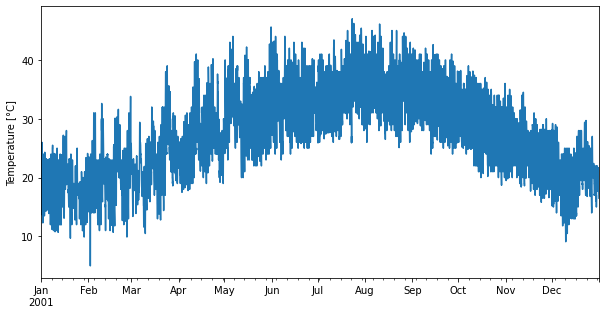

In [7]:
df['temp'].plot(figsize=(10, 5), ylabel='Temperature [°C]')

Weather being weather, we can only judge at this point general patterns.

Abu Dhabi is in the Northern hemisphere, so the warmer season, summer, will be June-September, and the cold one, winter, December-March.
This location is in a hot desert climate, so it will be hot in the summer and cold it winter, but since it is close to a coastal location, it will not be as hot or as cold as in the middle of the desert.

* Temperature ranging between 5 and 47 °C in the year is believable. 
* Temperatures get hotter in the summer and colder in winter as we expect.
* There seems to be a strange cold day in early February. That might have been the case or it might have been an error in the reading. In any case, this does not matter as we are interested in hot conditions.

In [8]:
df['relhum'].plot(figsize=(10, 5), ylabel='Relative humidity [%]')

<AxesSubplot:ylabel='Relative humidity [%]'>

Relative humidity is hard to appraise because it depends on temperature. 
From physics, relative humidity can only be in the 0-100% range.
If the water content is kept the same during a day, the relative humidity will be higher at night because of the colder temperature, and lower during the day because of the hotter temperatures. 
Thus, the table and figure look sensible.

# Heat stress index implementation

As mentioned above, we will use Steadman's apparent temperature for indoors.
Checking the original paper, we see that the apparent temperature (°C) is given by

$
\theta_{\text{apparent}} = -1.3 + 0.92 \cdot \theta + 2.2 \cdot \frac{p}{1000}
$

where,
* $\theta$ is the external air temperature (°C) and
* $p$ is the partial vapour pressure (Pa).

For example, for air at 35 °C and 90%:
* $p = 5061$ Pa (we will see where this number comes from next).
* $\theta_{\text{apparent}} = -1.3 + 0.92 \cdot 35 + 2.2 \cdot \frac{5061}{1000} = 42.03$ °C.

What does this number tells us? Intuitively it tells us that a warm temperature (35 °C) under moist conditions (90% relative humidity) can be normalised to a standard environment at 42 °C, which is rather hot according to this scale.

Since we need the partial vapour pressure $p$ for this model we will look into this next.

## Partial vapour pressure

The partial vapour pressure ($p$, in Pa) can be calculated as

$
p = p_{sat} \cdot \phi
$

where,
* $p_{sat}$ is the saturation pressure of water (Pa) and
* $\phi$ is the relative humidity, (n.d., typically reported in %).

Now the problem becomes finding out the saturation pressure of water ($p_{sat}$). 
This is a function of the air temperature, and there are many models available to calculate it.
One of them is

$
p_{sat} = 133.322 \cdot e ^ {18.6686 - \frac{4030.183}{\theta + 235}}
$

where,
* $\theta$ is the air temperature (°C).

For example, for air at 35 °C and 90% relative humidity:
* $p_{sat} = 133.322 \cdot e ^ {18.6686 - \frac{4030.183}{\theta + 235}} = 5623.8$ (Pa), then
* $p = p_{sat} \cdot \phi = 5623.8 \cdot \frac{90}{100} = 5061$ (Pa).

Note that differences of 1 Pa are negligible here, even greater differences (in this field, most people really use kPa).

In Python, we could do the following:

In [9]:
def part_vap_pressure(temp, relhum):
    """
    Calculate the partial vapour presure [Pa].
    
    Arguments
    ---------
    temp:
        Air temperature [°C].
    relhum:
        Relative humdity [%].
        
    Example
    -------
    >>> round(part_vap_pressure(temp=50, relhum=90), 0)
    5061.4
    
    """
    return 133.322 * np.exp(18.6686 - 4030.183 / (temp + 235)) * relhum / 100

# Let's check that the function gives the number we expect for the example above
assert np.isclose(part_vap_pressure(temp=35, relhum=90), 5061, atol=0.5)

Note some key features of the Python code above:
* The routine to calculate partial vapour pressure has been encapsulated in a function.
* The function takes all the arguments it needs explicitly: temperature and relative humidity.
* The function has a *docstring*, a bit of text that describes what the function does, its arguments, and units. It even includes a small example based on the previous manual example.

It is fundamental to test that the function does what we expect it to do:
* The `assert` verifies that the expression that follows is `True` and if it is not, it will report an error.
    * The expression checks if the partial vapour pressure that the function gives at 35 °C and 90% is equal to 5061 $\pm$ 0.5.
    * Since the condition is satisfied, it does not report any errors.
    
Thus, things look correct. 
Of course, we would need proper testing to make sure there are no mistakes.
Testing is beyond the purposes of this course / demonstration, but it does not mean is not important.
If you want to know more about testing in Python, [pytest](https://docs.pytest.org/) is a popular place to start.

## Calculate apparent temperature

We can calculate the apparent temperature now:

In [10]:
def apparent_temperature(temp, p):
    """
    Calculate the apparent temperature [°C].
    
    Arguments
    ---------
    temp:
        Outdoor air temperature [°C].
    p:
        Outdoor partial vapour pressure [Pa].
    
    Example
    -------
    >>> round(apparent_temperature(temp=35, p=5061), 2)
    42.03
    
    """
    return -1.3 + 0.92 * temp + 2.2 * p / 1000

assert np.isclose(apparent_temperature(temp=35, p=5061), 42.03, atol=0.005)

That seems correct.

Rather than working with temperature and partial vapour pressure, we could work directly with temperature and relative humidity.
We could redefine the function `apparent_temperature(temp, p)` to `apparent_temperature(temp, relhum)` or simply write a new function like `apparent_temperature_relum(temp, relhum)` if we are interested in keeping both versions for some reason.

In [11]:
def apparent_temperature_relhum(temp, relhum):
    """
    Calculate the apparent temperature [°C].
    
    Arguments
    ---------
    temp:
        Outdoor air temperature [°C].
    relhum:
        Outdoor relative humidity [%].
    
    Example
    -------
    >>> round(apparent_temperature_rh(temp=35, relhum=90), 2)
    42.03
    
    """
    p = part_vap_pressure(temp=temp, relhum=relhum)
    return apparent_temperature(temp=temp, p=p)

assert np.isclose(apparent_temperature_relhum(temp=35, relhum=90), 42.03, atol=0.005)

We could actually plot a chart to see how apparent temperature changes at different temperatures and relative humidity levels:

In [12]:
temps = np.linspace(0, 50)   # Get a bunch of temperatures between 0 and 50.
rhs   = np.linspace(0, 100)  # Get a bunch of relative humidities between 0 and 100.

# Data to plot
xx, yy = np.meshgrid(temps, rhs)      # Create a grid using the previous two vectors
zz = apparent_temperature_relhum(xx, yy)  # Calculate the apparent temperature at each grid point

# Plot
fig, ax = plt.subplots(figsize=(15, 5))

# Define the plot extent (left, right, bottom, top)
extent = (temps.min(), temps.max(), rhs.min(), rhs.max())

# Plot array `zz` with the apparent temperature as an image
im = ax.imshow(zz, origin='lower', extent=extent, aspect=.2)
# with a colobar
cb = fig.colorbar(im)

# Add contour lines
cs = ax.contour(zz, origin='lower', colors='white', extent=extent)
# with labels
ax.clabel(cs, inline=True, fmt='%1d', fontsize=11)

plt.xlabel('Temperature [°C]')
plt.ylabel('Relative humidity [%]')
plt.title('Apparent temperature [°C]')

plt.tight_layout()
plt.show()

This shows graphically the variation of apparent temperature as air temperature and relative humidity changes.

The library behind this plot (and actually the previous plots as well) is [matplotlib](https://matplotlib.org/stable/users/index.html),
a wonderful library to produce high-quality figures.
To newcomers, matplotlib can be a bit overwhelming:
* there are seemingly different ways to achieve the same thing,
* it offers a vast amount of functionality and options,
* the learning curve varies depending on what you need to do.

In practice, it is common to search on the internet the particular thing you are looking for.
* [Basic tutorials](https://matplotlib.org/stable/users/getting_started/index.html) are helpful. 
* [Matplotlib documentation is great](https://matplotlib.org/stable/users/index.html).
* There are [cheatsheets](https://github.com/matplotlib/cheatsheets) created by the community that are quite handy.
* Books like [this one](https://github.com/rougier/scientific-visualization-book).

This is just the tip of the iceberg. There are [many other options](https://www.youtube.com/watch?v=FytuB8nFHPQ) to visualise data in Python!

# Heat stress index at the location

Now that we are familiar with apparent temperature and that the implementation in Python seems correct, we can continue.

The next step is to calculate the apparent temperature for the location given the weather data we loaded.

In [13]:
df['temp_apparent'] = apparent_temperature_relhum(df['temp'], relhum=df['relhum'])
df

temp  relhum  temp_apparent
2001-01-01 00:00:00  16.0      78      16.537720
2001-01-01 01:00:00  15.6      82      16.246669
2001-01-01 02:00:00  15.1      85      15.798770
2001-01-01 03:00:00  14.8      87      15.535314
2001-01-01 04:00:00  14.4      88      15.121138
...                   ...     ...            ...
2001-12-31 19:00:00  17.9      67      18.189387
2001-12-31 20:00:00  17.5      69      17.834009
2001-12-31 21:00:00  17.2      71      17.587236
2001-12-31 22:00:00  16.8      73      17.226579
2001-12-31 23:00:00  16.5      75      16.975046

[8760 rows x 3 columns]

## Explore and analyse results

<AxesSubplot:>

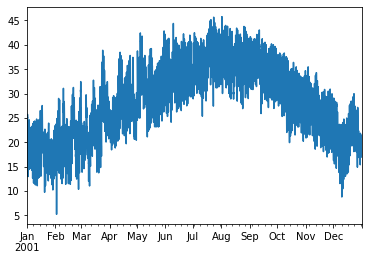

In [14]:
df['temp_apparent'].plot()

We could compare how different the apparent temperature is from the air temperature.

In [15]:
fig, ax = plt.subplots()

# Plot air temperature vs apparent temperature
df.plot(ax=ax, x='temp', y='temp_apparent', kind='scatter')

# Add a reference line y=x
ax.axline((0, 0), slope=1, color='red')

# Make sure the X and Y axis are at the same scale
ax.set_aspect(1)

plt.xlabel('Air temperature [°C]')
plt.ylabel('Apparent temperature [°C]')
plt.grid()
plt.show()

We could also explore the amount of hours above/below certain temperatures.

In [16]:
threshold = 35  # This is just to plot a vertical line

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df['temp_apparent'], bins=np.arange(0, 46, 1), cumulative=-1)
ax.axvline(x=threshold, color='red', ls='--')
plt.xlabel('Apparent temperature [°C]')
plt.ylabel('Hours in the year [h]')
plt.title(f'Cumulative histogram ({threshold=} °C)')
plt.grid()
plt.show()

We could also add columns to the tables with different thresholds and report `1` if it was surpassed at that hour, or `0` otherwise.

In [17]:
thresholds = [30, 35, 40, 45]
cols = []
for threshold in thresholds:
    col = str(threshold)
    df[col] = np.where(df['temp_apparent'] >= threshold, 1, 0)
    cols.append(col)
df

temp  relhum  temp_apparent  30  35  40  45
2001-01-01 00:00:00  16.0      78      16.537720   0   0   0   0
2001-01-01 01:00:00  15.6      82      16.246669   0   0   0   0
2001-01-01 02:00:00  15.1      85      15.798770   0   0   0   0
2001-01-01 03:00:00  14.8      87      15.535314   0   0   0   0
2001-01-01 04:00:00  14.4      88      15.121138   0   0   0   0
...                   ...     ...            ...  ..  ..  ..  ..
2001-12-31 19:00:00  17.9      67      18.189387   0   0   0   0
2001-12-31 20:00:00  17.5      69      17.834009   0   0   0   0
2001-12-31 21:00:00  17.2      71      17.587236   0   0   0   0
2001-12-31 22:00:00  16.8      73      17.226579   0   0   0   0
2001-12-31 23:00:00  16.5      75      16.975046   0   0   0   0

[8760 rows x 7 columns]

And then summarise results by taken the total hours per month to get an idea of how conditions are.

In [18]:
df_thresholds = df[cols].resample('M').sum()
df_thresholds

30   35   40  45
2001-01-31    0    0    0   0
2001-02-28   10    0    0   0
2001-03-31   66   12    0   0
2001-04-30  162   38    0   0
2001-05-31  478  179   21   0
2001-06-30  601  317   59   0
2001-07-31  717  487  148   2
2001-08-31  715  504  171   1
2001-09-30  660  378   50   0
2001-10-31  379   89    0   0
2001-11-30   87    1    0   0
2001-12-31    0    0    0   0

The code above makes use of [pandas wonderful syntax to work with time series data](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling).
* `df` contains hourly data.
* We want some of that data only (the thresholds).
* We want to go from hourly values to monthly values, an operation known as 'resampling'.
* There are several ways to resample data: taking the monthly maximum, minimum, average, sum...
  * In this case, we want the total amount of hours in a month, so it would be the sum.
  
Thus, we select the columns we want (`df[cols]`), resample by month (`.resample('M')`) using the sum (`.sum()`).

# Reporting

There is a template already prepared that contains how the report will look, and it is in `1-input/report-template.xlsx`.
Take a moment to get familiar with the file, and see the inputs it requires from Python.
Notice that the sheet `report` has a title, three figures and a table.
  * The table hosts the numbers directly (the cells do not contain formulas).
  * The figures read the data from the sheet `data`.
  * The title of the report uses the location name provided in the sheet `data` as well.

The approach here will be to:
1. Read the name of the location from the EPW file.
2. Copy the report template to the output folder, and give it the name of the location to identify things easily.
3. Populate the output with the information available.

In [19]:
# Python standar library
from shutil import copy  # Function to copy files

# Third party modules
import xlwings as xw  # One of the several libraries in Python to work with Excel files

## Location name

The name of the location is conveniently reported in the first line of the EPW file.
It is a bit on an overkill to do it with pandas, but entirely possible.

In [20]:
info = pd.read_csv(path, nrows=1, header=None)
info

0          1  2    3          4       5      6      7    8     9
0  LOCATION  ABU DHABI  -  ARE  IWEC Data  412170  24.43  54.65  4.0  27.0

In [21]:
# The name is in row 0, column 1, and we can convert the string to Title Case with `.title()`
location = info.at[0, 1].title()
location

'Abu Dhabi'

## Prepare output report file

In [22]:
path_tpl = '1-input/report-template.xlsx'
path_out = f'2-output/report-{location}.xlsx'
copy(path_tpl, path_out)

print(f"File `{path_tpl}` copied to `{path_out}`")

File `1-input/report-template.xlsx` copied to `2-output/report-Abu Dhabi.xlsx`


## Populate the report

Looking at the Excel coordinates of where the information is expected, we can start populating the report.

The following makes heavy use of 
* [`xlwings`](https://docs.xlwings.org/en/stable/) to write the data into Excel,
* [`pandas`](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling) to work with time series as we did above.

The code below is explained line by line at high level.
Some additional comments are provided below if you want to know more about how it works.

In [23]:
# Load the workbook
wb = xw.Book(path_out)

# Write the value of a cell
wb.sheets['data'].range('C3').value = location

# Write a list of values, starting in a particular cell
# Technical detail: In the `xlwings` package, the default is to write lists/arrays per row
#                   To write lists/arrays as colums we need to use `tranpose=True`
# - Temperature
wb.sheets['data'].range('F4').options(transpose=True).value = df['temp'].resample('D').min().resample('M').mean().to_numpy()
wb.sheets['data'].range('G4').options(transpose=True).value = df['temp'].resample('D').max().resample('M').mean().to_numpy()
# - Relative humidity
wb.sheets['data'].range('F19').options(transpose=True).value = df['relhum'].resample('D').min().resample('M').mean().to_numpy()
wb.sheets['data'].range('G19').options(transpose=True).value = df['relhum'].resample('D').max().resample('M').mean().to_numpy()
# - Apparent temperature
wb.sheets['data'].range('F34').options(transpose=True).value = df['temp_apparent'].resample('M').min().to_numpy()
wb.sheets['data'].range('G34').options(transpose=True).value = df['temp_apparent'].resample('M').max().to_numpy()

# Write table
wb.sheets['report'].range('L24').value = df_thresholds.to_numpy()

# Save
wb.save(path_out)

# Close the workbook
wb.close()

## Notes on the code

In `xlwings`, like in other similar packages, starts by opening the workbook (the Excel file).

In Excel, cells within the same file (workbook) can be addressed with the sheet name and the coordinate 
(for example, the sheet `data` and cell `C3`) and
cells can contain quite a bit of information (for example, cells hold values numbers, text, formulas, etc. but also styles like font type, text color, background colour, etc.).
Thus, to point to the *value* of the cell `C3` in sheet `data` in the workbook `wb`:
`wb.sheets['data'].range('C3').value`.

That works well for single values. If we have the list `[1, 2, 3]` to be written in cells A1, B1, C1 respectively, we have two options:
* Say that the first item in the list goes to A1, that the second goes to B1 and that the third one goes to C1, or
* Note that in `xlwings`, we can write several values at the same time, so `wb.sheets['mysheet'].range('A1').value = [1, 2, 3]` has the desired effect.
In `xlwings` the default is to write 'per row'. If we wanted to write the list per column (this is, to cells A1, A2 and A3), we need to use
`wb.sheets['mysheet'].range('A1').options(transpose=True).value = [1, 2, 3]`.

Turning now to the pandas bit, noe that there are two types of figures in the report:
* Air temperature and relative humidity report 'the monthly range of **average** daily min and max'.
  * For example, for air temperature in sheet `data`, column starting `F4`, we need to write the average daily minimums.
    * This is what `df['temp'].resample('D').min().resample('M').mean().to_numpy()` does.
    * `df['temp']` select the temperature, then
    * `.resample('D').min()` resamples hourly values (8760 values) to **daily values** (365 values) by taking the daily **minimum**, then
    * `.resample('M').mean()` resamples the daily values (365 values) to **monthly values** (12 values) by taking the monthly **mean**, then
    * `.to_numpy()` transforms the object to an array with just the values of the pandas object.
* Apparent temperature requires the 'monthly range of **absolute** min and max'.
  * This is similar to the previous, but we do not need the intermediate step of daily values. We can take directly the minimum and maximum over a month.
  
It is also possible to write whole tables directly, which is what `wb.sheets['report'].range('L24').value = df_thresholds.to_numpy()` does.

Finally, we need to save the changes to the file, and let Python know that it can close the file.

# Final remarks

This notebook showcases *a way* of going about this problem. 
This is really a 'first draft' of the notebook that intends to show the thinking process as it took place.
Now that there is a solution in place that works, it would make sense to sort things out a bit better, and clean up things where needed.
At the very least, the notebook should have annotations on why you did the things you did.
Imagine that you open a notebook in a couple of years: will you be able to follow (1) the code and (2) its rationale?

A good habit with notebooks that do not take too long to run is to reset the kernel and run things all over again to make sure that there are no problems.
The reason is that in notebooks one can go to previous cells, change something, then go directly to a cell a few rows below. Thus, the visual order top-to-bottom might not match the order in which the cells where actually executed. This then becomes a problem when you reopen the notebook or give it to somebody else.

Similarly to this example, you will need to think carefully about what you need to do in your exercise.
1. Devise a strategy.
2. See how you can accomplish that with Python.
3. Give it a go in your notebook, documenting things as you go along.